# **Trabajo de Modelos de Logística**

La cadena de supermercados *Dild* va a instalarse en una nueva ciudad y pretende abrir varias tiendas. Los potenciales clientes acudirán a la tienda que tengan abierta más cercana (distancia euclídea). Dado que los clientes no se reparten de forma homogenea, habrá tiendas que tendrán mayor demanda que otras. En particular, el problema que vas a resolver tiene 500 clientes y 30 potenciales ubicaciones en las que colocar supermercados.




El siguiente fragmento de código permite cargar los datos necesarios para plantear este problema (no todos los datos se utilizan inicialmente).

In [30]:
from gurobipy import *
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Descargar el archivo desde GitHub
url = 'https://github.com/joseani/ModelosDeLogistica/raw/main/datos2025.npz'

# Descargar el archivo desde GitHub
res = requests.get(url)

# Cargar el archivo en memoria
with BytesIO(res.content) as f:
    loaded_data = np.load(f)
    coordenadasI = loaded_data["coordenadasI"] # Coordenadas en el plano del conjunto de clientes
    coordenadasJ = loaded_data["coordenadasJ"] # Coordenadas en el plano del conjunto de potenciales instalaciones
    demandas = loaded_data["demandas"] # Demanda de cada cliente (ejercicio 3)
    coordenadasH = loaded_data["coordenadasH"] # Coordenadas en el plano del conjunto de instalaciones rivales (ejercicio 4)


La ubicación de los clientes de la ciudad y la ubicación de las potenciales instalaciones se proporcionan en las variables **coordenadasI** y **coordenadasJ**, respectivamente. Se muestra a continuación:

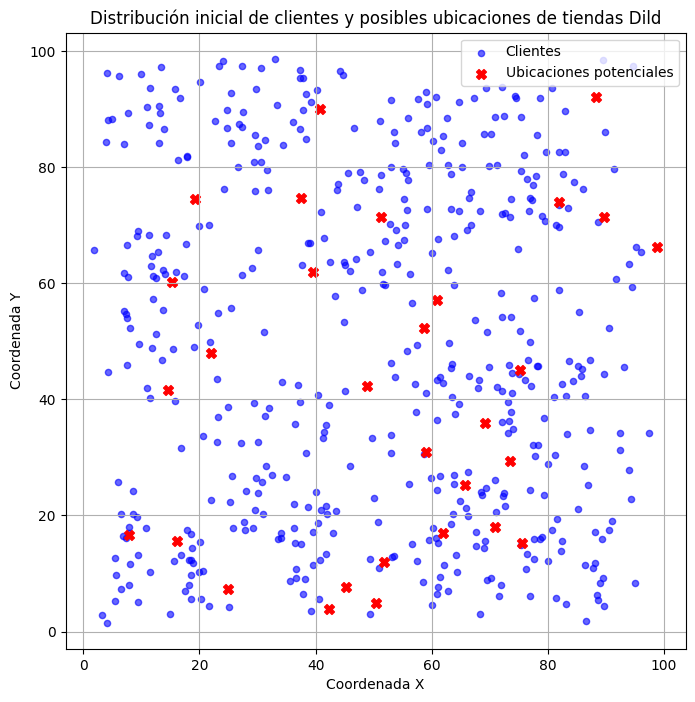

In [4]:
plt.figure(figsize=(8, 8))
plt.scatter(coordenadasI[:, 0], coordenadasI[:, 1],
            label="Clientes", alpha=0.6, s=20, c='blue')
plt.scatter(coordenadasJ[:, 0], coordenadasJ[:, 1],
            label="Ubicaciones potenciales", marker='X',
            s=50, c='red')
plt.title("Distribución inicial de clientes y posibles ubicaciones de tiendas Dild")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.legend()
plt.grid(True)
plt.axis('equal')  # mismo escala en ejes X e Y
plt.show()

**Nota:** en los ejercicios que se proponen a continuación, es posible que la resolución se demore demasiado tiempo. Si consideras que es necesario limitar el tiempo de resolución, puedes hacerlo escribiendo algo como: *modelo.Params.TimeLimit = 600*, para que termine en 10 minutos, por ejemplo.
<br><br>


# **Ejercicios**

**Ejercicio 1.** El objetivo es ubicar 5 supermercados *Dild*, dentro de las posibles localizaciones, de manera que se minimice la diferencia entre el número de clientes que acuden a la tienda con mayor afluencia y el número de clientes que acuden a la tienda con menor afluencia.

Escribe un modelo de optimización que permita resolver este problema. Además de la validez del modelo, se valorará el uso adecuado de la notación, la descripción de variables, función objetivo, restricciones u otros elementos que aparezcan en el modelo.



**Ejercicio 2.** Resuelve el modelo planteado en el apartado anterior utilizando Gurobi y describe la solución obtenida.

**Ejercicio 3.** Considera ahora que cada cliente tiene una demanda específica (se proporciona en la variable **demandas**). Modifica convenientemente el modelo propuesto en el ejercicio 1, de manera que ahora el objetivo sea mininimizar la diferencia de demandas, entre el supermercado que atiende mayor demanda y el que atiende menor demanda. Describe cuáles son las modificaciones que has realizado sobre el modelo y, después, resuelvelo con Gurobi y describe la solución obtenida.

**Ejercicio 4.** Resulta que en la ciudad ya está implantada otra cadena de supermercados, *Adli*, que tiene características similares a *Dild* y que por tanto es competencia directa. Los clientes de la ciudad se decantarán por la tienda que tengan más cerca, independientemente de si es de una y otra cadena. La cadena *Adli* cuenta con 8 tiendas, cuyas ubicaciones se proporcionan en la variable **coordenadasH**.

Supón que, en este ejercicio, únicamente se desa saber cuál es el número mínimo de tiendas *Dild* que le permitiría a *Dild* tener más clientes que *Adli*, y dónde podrían estar ubicadas.

Describe el modelo matemático correspondiente, resuévelo con gurobi y describe la solución.

In [5]:
WLSACCESSID="adeaa93d-fb26-4773-9678-7662bf5a33cc"
WLSSECRET="a8d49419-c400-4927-9697-28b4ca90e294"
LICENSEID=2641339

env = Env(params = {"WLSACCESSID" : WLSACCESSID, "WLSSECRET" : WLSSECRET, "LICENSEID" : LICENSEID})
# env

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2641339
Academic license 2641339 - for non-commercial use only - registered to jg___@ikasle.ehu.eus


## Ejercicio 1  
El objetivo es ubicar 5 supermercados Dild entre las posibles localizaciones de modo que se minimice la diferencia entre el número de clientes de la tienda con mayor afluencia y la tienda con menor afluencia.

### Planteamiento matemático

**Conjuntos y parámetros**  
- $I=\{1,\dots,n\}$: conjunto de clientes.  
- $J=\{1,\dots,m\}$: conjunto de posibles localizaciones para las tiendas.  
- $p=5$: número de tiendas a abrir.
- $d_{ij}$: distancia euclídea entre el cliente $i$ (ubicado en $x_i,y_i$) y la ubicación $j$ (en $X_j,Y_j$), calculada como:
  $$
  d_{ij} = \sqrt{(x_i - X_j)^2 + (y_i - Y_j)^2}.
  $$

**Variables de decisión**  
$$
x_{ij} =
\begin{cases}
1, & \text{si el cliente $i$ se asigna a la tienda $j$},\\
0, & \text{en otro caso},
\end{cases}
\quad i\in I,\;j\in J.
$$

$$
z_{j} =
\begin{cases}
1, & \text{si abrimos una tienda en la ubicación $j$},\\
0, & \text{en otro caso},
\end{cases}
\quad j\in J.
$$
- Número de clientes en la tienda más concurrida
$$
u\in\mathbb{Z}_{\ge0}\colon\quad u\;=\;\max_{j\in J}\sum_{i\in I}x_{ij},
$$  
  
- Número de clientes en la tienda menos concurrida
$$
\ell\in\mathbb{Z}_{\ge0}\colon\quad \ell\;=\;\min_{j\in J}\sum_{i\in I}x_{ij}.
$$  
  

---

### Función objetivo

$$
\min\;\,u - \ell
$$

Minimizamos la diferencia $u-\ell$.

### Restricciones (sujeto a)

1. **Cada cliente va a una sola tienda**  
   $$
   \sum_{j\in J} x_{ij} = 1,
   \quad \forall\,i\in I.
   $$

2. **Cálculo de la carga máxima en cada tienda abierta**  
   $$
   \sum_{i\in I} x_{ij} \;\le\; u,
   \quad \forall\,j\in J.
   $$


3. **Cálculo de la carga mínima en cada tienda abierta**  
   $$
   \ell \;\le\; \sum_{i\in I} x_{ij} \;+\; n\,\bigl(1 - z_j\bigr)
   \quad\forall\,j\in J,
   $$
   con $n=|I|$. Es decir, el número total de clientes.

4. **Número de tiendas a abrir = 5**  
   $$
   \sum_{j\in J} z_{j} = p.
   $$

5. **Vínculo apertura–asignación**  
   Un cliente sólo puede ir a una tienda si está abierta:
   $$
   x_{ij}\;\le\;z_{j},
   \quad \forall\,i\in I,\;j\in J.
   $$

6. **Asignación a la tienda abierta más cercana**
   $$
   \sum_{a\in J} d_{ia}x_{ia} + (M_i-d_{ij}) z_j \le M_i \quad \forall i\in I,\,j\in J
   $$
   con $M_i = d_{i\,(m-p+1)}^{\uparrow}, \quad \forall i\in I$.


7. **Dominio de las variables (binarias o enteras positivas)**  
   $$
   x_{ij}\in\{0,1\},\quad
   z_{j}\in\{0,1\},\quad
   u,\ell\in\mathbb{Z}_{\ge0}.
   $$

---

**Explicación de las restricciones**
- (1) garantiza cobertura única de todos los clientes.
- (2) garantiza que $u$ sea al menos la carga de cualquier tienda abierta.
- (3) con Big-$M$, $\ell$ queda como la carga mínima solo entre tiendas abiertas.
- (4) fuerza la apertura de exactamente $p=5$ tiendas.
- (5) impide asignar clientes a ubicaciones no seleccionadas.  
- (6) fuerza que cada cliente se asigne a su tienda abierta más cercana. La distancia de la tienda que realmente obtiene $x_{ia}=1$ no debe ser mayor que $d_{ij}$; en otras palabras, no debe estar más lejos que cada otro sitio abierto, lo que implica que es el más cercano (se permiten empates).
- (7) fija los dominios binario y entero de las variables.

Con este modelo se obtiene la solución que minimiza la diferencia de afluencia entre la tienda con más clientes y la de menos clientes. Como no tenemos ningún límite de “radio de servicio” o distancia máxima $D$, no incluimos esto en las restricciones.

## Ejercicio 2: Formulación del modelo en Gurobi

In [6]:
# Número de clientes y su índice
nI = coordenadasI.shape[0]
I  = range(nI)

# Número de ubicaciones y su índice
nJ = coordenadasJ.shape[0]
J  = range(nJ)

# Número de tiendas a abrir
p  = 5
print(f"nI = {nI}, nJ = {nJ}, p = {p}")

nI = 500, nJ = 30, p = 5


In [9]:
# n = número total de clientes = 500
n = len(I)
# --- Cálculo de la matriz de distancia euclídea d_{ij} ---
d = {
    (i, j): np.hypot(
        coordenadasI[i, 0] - coordenadasJ[j, 0],
        coordenadasI[i, 1] - coordenadasJ[j, 1]
    )
    for i in I for j in J
}

# --- Crear modelo ---
model = Model("Ejercicio1", env=env)

# --- Variables de decisión ---
arcosIJ = [(i,j) for i in I for j in J]
x = model.addVars(arcosIJ,vtype=GRB.BINARY, name="x")   # 1 = cliente i asignado a tienda j
z = model.addVars(J,      vtype=GRB.BINARY, name="z")   # 1 = abrimos tienda en j
u = model.addVar(         vtype=GRB.CONTINUOUS, name="u")  # carga máxima entre tiendas abiertas
l = model.addVar(         vtype=GRB.CONTINUOUS, name="l")  # carga mínima entre tiendas abiertas
# Estas dos ultimas se definen continuas para acelerar el cálculo de la solución

# --- Restricciones ---

# 1) Cada cliente asignado exactamente a una tienda
model.addConstrs(
    (quicksum(x[i,j] for j in J) == 1
     for i in I),
    name="AsignacionUnica"
)

# 2) Definición de u = máxima carga de las tiendas abiertas
model.addConstrs(
    (quicksum(x[i,j] for i in I) <= u
     for j in J),
    name="CargaMaxima"
)

# 3) Definición de l = mínima carga de las tiendas abiertas (Big-M)
model.addConstrs(
    (l <= quicksum(x[i,j] for i in I) + n * (1 - z[j])
     for j in J),
    name="CargaMinima"
)

# 4) Se abren exactamente p tiendas
model.addConstr(
    quicksum(z[j] for j in J) == p,
    name="NumTiendas"
)

# 5) Sólo se puede asignar a tiendas abiertas
model.addConstrs(
    (x[i,j] <= z[j]
     for i in I for j in J),
    name="AperturaAsignacion"
)

# 6) Sólo se puede asignar a la tienda abierta más cercana
# --- Big-M POR CLIENTE – versión ajustada ---------------------------
#  M_i = distancia (m-p+1)-ésima más corta
m = len(J)
M = {
    i: sorted(d[i, j] for j in J)[m - p]   #(m-p+1)-ésimo
    for i in I
}
model.addConstrs(
    ( quicksum(d[i, a] * x[i, a] for a in J)
      + (M[i] - d[i, j]) * z[j] <= M[i]
      for i in I for j in J ),
    name="MasCercanaAbierta"
)

# --- Objetivo ---
# minimizar u - l
model.setObjective(u - l, GRB.MINIMIZE)

# --- Resolución ---
model.Params.TimeLimit = 60 * 30  # 30 minutos límite
model.optimize()

Set parameter TimeLimit to value 1800
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  1800

Academic license 2641339 - for non-commercial use only - registered to jg___@ikasle.ehu.eus
Optimize a model with 30561 rows, 15032 columns and 539620 nonzeros
Model fingerprint: 0x27afa6af
Variable types: 2 continuous, 15030 integer (15030 binary)
Coefficient statistics:
  Matrix range     [2e-04, 5e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Found heuristic solution: objective 164.0000000
Presolve removed 5000 rows and 2500 columns (presolve time = 5s)...
Presolve removed 6711 rows and 3356 columns
Presolve time: 5.80s
Presolved: 23850 rows, 11676 columns, 223140 nonzeros
Variable types: 0 continuous, 11676 integer (11674 binary)
Deterministic concurrent LP opti

In [10]:
abiertas_ex1 = [ j for j in J if z[j].X > 0.5 ]
print("Tiendas abiertas (Ej 1):", abiertas_ex1) # 5 tiendas abiertas

Tiendas abiertas (Ej 1): [2, 4, 5, 7, 12]


Distribución de clientes asignados

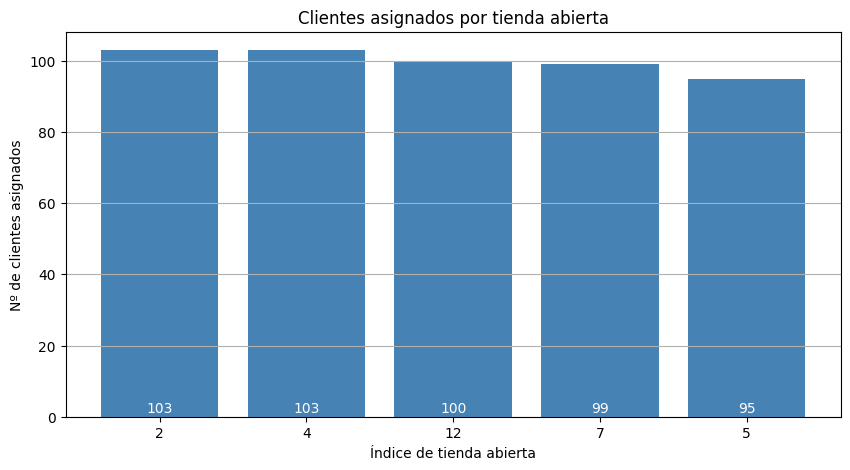

Máx clientes tienda: 103
Mín clientes tienda: 95
Spread: 8


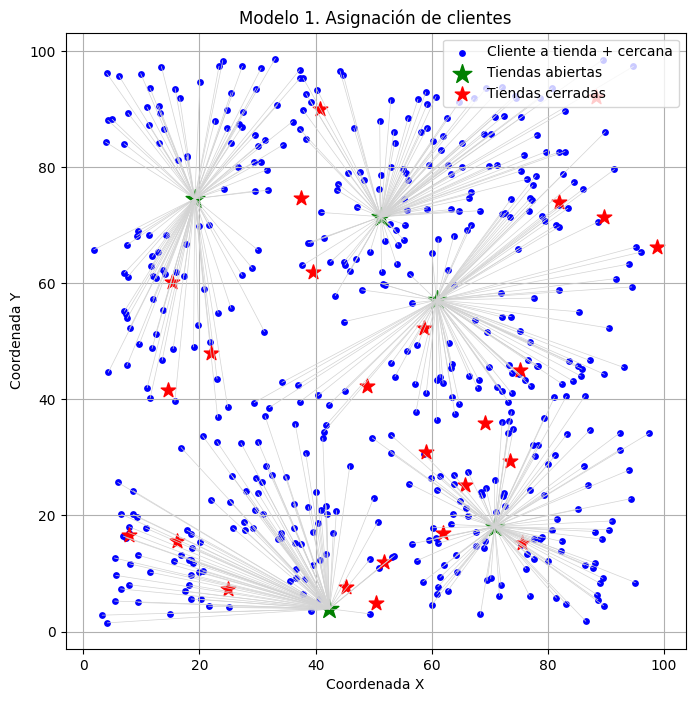

In [11]:
abiertas_ex1 = [j for j in J if z[j].X > 0.5]

clientes_por_tienda = {
    j: sum(int(x[i, j].X > 0.5) for i in I)     # cuenta clientes asignados
    for j in abiertas_ex1
}
ordenado = sorted(clientes_por_tienda.items(), key=lambda t: t[1], reverse=True)
tiendas, clientes = zip(*ordenado)

plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(tiendas)), clientes, color="steelblue")
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        0.5,                              
        f"{int(height)}",
        ha="center", va="bottom",
        color="white", fontsize=10
    )

plt.xticks(range(len(tiendas)), tiendas)
plt.xlabel("Índice de tienda abierta")
plt.ylabel("Nº de clientes asignados")
plt.title("Clientes asignados por tienda abierta")
plt.grid(axis="y")
plt.show()

print(f"Máx clientes tienda: {max(clientes)}")
print(f"Mín clientes tienda: {min(clientes)}")
print(f"Spread: {max(clientes)-min(clientes)}")

# ---------------------------
# 2)  MAPA  Clientes vs. tiendas
# ---------------------------
mal_x, mal_y   = [], []
bien_x, bien_y = [], []
segments       = []

for i in I:
    # tienda efectivamente asignada
    j_asig = next(j for j in J if x[i, j].X > 0.5)
    dist_asig = d[i, j_asig]

    # distancia mínima a cualquiera de las abiertas
    dist_min_abierta = min(d[i, j] for j in abiertas_ex1)

    xi, yi = coordenadasI[i]
    if dist_asig > dist_min_abierta + 1e-6:   # tolerancia numérica
        mal_x.append(xi);  mal_y.append(yi)
    else:
        bien_x.append(xi); bien_y.append(yi)

    # segmento visual cliente→tienda asignada
    xj, yj = coordenadasJ[j_asig]
    segments.append(((xi, yi), (xj, yj)))

plt.figure(figsize=(8, 8))
for (x0, y0), (x1, y1) in segments:
    plt.plot([x0, x1], [y0, y1], c="lightgrey", lw=0.5)

# clientes
plt.scatter(bien_x, bien_y, c="blue",  s=15, label="Cliente a tienda + cercana")
if mal_x:
    plt.scatter(mal_x, mal_y, c="red", s=25, label="Cliente NO va a tienda + cercana")

# tiendas
plt.scatter(coordenadasJ[abiertas_ex1, 0],
            coordenadasJ[abiertas_ex1, 1],
            marker="*", c="green", s=200, label="Tiendas abiertas")
cerradas = [j for j in J if j not in abiertas_ex1]
plt.scatter(coordenadasJ[cerradas, 0],
            coordenadasJ[cerradas, 1],
            marker="*", c="red",   s=120, label="Tiendas cerradas")

plt.title("Modelo 1. Asignación de clientes")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.legend(loc="best")
plt.grid(True)
plt.axis("equal")
plt.show()

La figura muestra en azul los 500 clientes repartidos por la ciudad y las 30 ubicaciones potenciales de tienda (marcadas con estrellas).  

- **Estrellas verdes**: las 5 localizaciones que el modelo decide abrir.  
- **Estrellas rojas**: las 25 ubicaciones restantes, que quedan cerradas.  

Se aprecia que las tiendas abiertas quedan bastante repartidas por todo el área, atendiendo a zonas con mayor concentración de clientes y buscando un reparto equilibrado de la carga de trabajo: no todas están en el “centro” ni todas en los “bordes”, sino distribuidas para acercarse a núcleos de demanda similares.

## Ejercicio 3  
El objetivo es ubicar 5 supermercados *Dild* entre las posibles localizaciones de modo que se minimice la diferencia entre la demanda (spread de demanda) atendida por la tienda con mayor carga y la que atiende la menor carga de demanda.

El cambio a realizar consta simplemente de re-definir la suma contra la que $u$ y $l$ se comparan: en lugar de $\sum_{i\in I}x_{ij}$, ahora debemos redefinir la carga como la carga total de demanda atendida en $j$, $\sum_{i\in I} \mathit{demandas}_i\,x_{ij}$.

### Planteamiento matemático

**Conjuntos y parámetros**  
- $I=\{1,\dots,n\}$: conjunto de clientes.  
- $J=\{1,\dots,m\}$: conjunto de posibles localizaciones para las tiendas.  
- $p=5$: número de tiendas a abrir.  
- $d_{ij}$: distancia euclídea entre el cliente $i$ y la ubicación $j$.  
- $\mathit{demandas}_i$: demanda (cantidad de pedido) del cliente $i$.  

**Variables de decisión**  
$$
x_{ij} =
\begin{cases}
1, & \text{si el cliente $i$ se asigna a la tienda $j$},\\
0, & \text{en otro caso},
\end{cases}
\quad i\in I,\;j\in J.
$$

$$
z_{j} =
\begin{cases}
1, & \text{si abrimos una tienda en la ubicación $j$},\\
0, & \text{en otro caso},
\end{cases}
\quad j\in J.
$$
$$
y_{j}\;\in\mathbb{R}_{\ge0}
\;:\;
y_{j} \;=\;\sum_{i\in I} \mathit{demandas}_i\,x_{ij}
\quad\text{(demanda total atendida en $j$).}
$$
$$
u\in\mathbb{R}_{\ge0}:
\;u=\max_{j\in J}\;y_{j},
\qquad
\ell\in\mathbb{R}_{\ge0}:
\;\ell=\min_{j\in J}\;y_{j}.
$$

---

### Objetivo

$$
\min\;\,u - \ell
$$

Minimizamos la diferencia $u-\ell$.

### Restricciones (sujeto a)

1. **Cada cliente va a una sola tienda**  
   $$
   \sum_{j\in J} x_{ij} = 1,
   \quad \forall\,i\in I.
   $$

2. **Demanda total atendida en cada tienda**  
   $$
   y_{j} = \sum_{i\in I} \mathit{demandas}_i \, x_{ij},
   \quad \forall\,j\in J.
   $$

3. **Cálculo de la demanda máxima**  
   $$
   y_{j} \;\le\; u,
   \quad \forall\,j\in J.
   $$

4. **Cálculo de la demanda mínima en tiendas abiertas**  
   $$
   \ell \;\le\; y_{j} + D\,\bigl(1 - z_{j}\bigr),
   \quad \forall\,j\in J,
   $$
   con $D = \sum_{i\in I}\mathit{demandas}_i$.

5. **Número de tiendas a abrir = 5**  
   $$
   \sum_{j\in J} z_{j} = p.
   $$

6. **Vínculo apertura–asignación**  
   Un cliente sólo puede ir a una tienda si está abierta:
   $$
   x_{ij}\;\le\;z_{j},
   \quad \forall\,i\in I,\;j\in J.
   $$

7. **Asignación a la tienda abierta más cercana**
   $$
   \sum_{a\in J} d_{ia}x_{ia} + (M_i-d_{ij}) z_j \le M_i \quad \forall i\in I,\,j\in J
   $$
   con $M_i = d_{i\,(m-p+1)}^{\uparrow}, \quad \forall i\in I$.


8. **Dominio de las variables (binarias o enteras positivas)**  
   $$
   x_{ij}\in\{0,1\},\quad
   z_{j}\in\{0,1\},\quad
   y_{j},\,u,\ell\in\mathbb{Z}_{\ge0}.
   $$


---

**Explicación de las restricciones**  
- (1) garantiza que cada cliente se asigne a exactamente una tienda.  
- (2) calcula la demanda total atendida en cada tienda a partir de las demandas individuales y las variables de asignación.  
- (3) asegura que $u$ sea al menos la demanda de cada tienda, de modo que $u$ represente la demanda máxima.  
- (4) mediante el Big-$M$, permite que $\ell$ sea la demanda mínima entre las tiendas abiertas (para tiendas cerradas la restricción queda desactivada).  
- (5) fuerza la apertura de exactamente $p$ tiendas.  
- (6) impide asignar clientes a tiendas que no estén abiertas.  
- (7) fuerza que cada cliente se asigne a su tienda abierta más cercana. La distancia de la tienda que realmente obtiene $x_{ia}=1$ no debe ser mayor que $d_{ij}$; en otras palabras, no debe estar más lejos que cada otro sitio abierto, lo que implica que es el más cercano (se permiten empates).
- (8) fija los dominios de las variables: $x_{ij}$ y $z_j$ binarias, $y_j$, $u$ y $\ell$ enteras no negativas.

In [12]:
nI = len(demandas) #500
nJ = len(coordenadasJ)
I = range(nI)
J = range(nJ)

# Matriz de distancias euclídeas d[i,j]
d = {
    (i, j): np.hypot(coordenadasI[i,0] - coordenadasJ[j,0],
                     coordenadasI[i,1] - coordenadasJ[j,1])
    for i in I for j in J
}

# D como suma total de demandas
D = float(demandas.sum())

# --- Crear y configurar modelo ---
model3 = Model("Ex3_Demanda", env=env)

# --- Variables de decisión ---
x = model3.addVars(I, J,vtype=GRB.BINARY, name="x")    # asignación cliente->tienda
z3 = model3.addVars(J,vtype=GRB.BINARY, name="z")      # abre tienda j

# enteras por claridad semántica
y = model3.addVars(J,vtype=GRB.INTEGER, name="y")      # demanda atendida en j
u = model3.addVar(vtype=GRB.INTEGER, name="u")         # demanda máxima
l = model3.addVar(vtype=GRB.INTEGER, name="l")         # demanda mínima

# --- Restricciones ---

# 1) Cada cliente a una sola tienda
model3.addConstrs(
    (quicksum(x[i,j] for j in J) == 1 for i in I),
    name="AsignUnica"
)

# 2) Definición de demanda total en cada tienda
model3.addConstrs(
    (y[j] == quicksum(demandas[i] * x[i,j] for i in I) for j in J),
    name="DefDemanda"
)

# 3) Demanda máxima
model3.addConstrs(
    (y[j] <= u for j in J),
    name="MaxDemanda"
)

# 4) Demanda mínima (D)
model3.addConstrs(
    (l <= y[j] + D * (1 - z3[j]) for j in J),
    name="MinDemanda"
)

# 5) Apertura de p tiendas
model3.addConstr(
    quicksum(z3[j] for j in J) == p,
    name="NumTiendas"
)

# 6) Solo asignar si la tienda está abierta
model3.addConstrs(
    (x[i,j] <= z3[j] for i in I for j in J),
    name="AperturaAsign"
)

# 7) Sólo se puede asignar a la tienda abierta más cercana
#  M_i = distancia (m-p+1)-ésima más corta
model3.addConstrs(
    ( quicksum(d[i, a] * x[i, a] for a in J)
      + (M[i] - d[i, j]) * z3[j] <= M[i]
      for i in I for j in J ),
    name="MasCercanaAbierta"
)

# --- Objetivo ---
# minimizar u - l
model3.setObjective(u - l, GRB.MINIMIZE)

# --- Resolución ---
model3.Params.TimeLimit = 60 * 30  # 30 minutos límite
model3.optimize()

Set parameter TimeLimit to value 1800
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  1800

Academic license 2641339 - for non-commercial use only - registered to jg___@ikasle.ehu.eus
Optimize a model with 30591 rows, 15062 columns and 524710 nonzeros
Model fingerprint: 0x56cbdcb2
Variable types: 0 continuous, 15062 integer (15030 binary)
Coefficient statistics:
  Matrix range     [2e-04, 3e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+03]
Found heuristic solution: objective 741.0000000
Presolve removed 5000 rows and 2500 columns (presolve time = 5s)...
Presolve removed 6758 rows and 3376 columns
Presolve time: 5.48s
Presolved: 23833 rows, 11686 columns, 209120 nonzeros
Variable types: 0 continuous, 11686 integer (11654 binary)
Deterministic concurrent LP opti

In [13]:
abiertas_ex3 = [ j for j in J if z3[j].X > 0.5 ]
print("Tiendas abiertas (Ej 3):", abiertas_ex3)

Tiendas abiertas (Ej 3): [1, 10, 17, 21, 26]


Distribución de clientes asignados

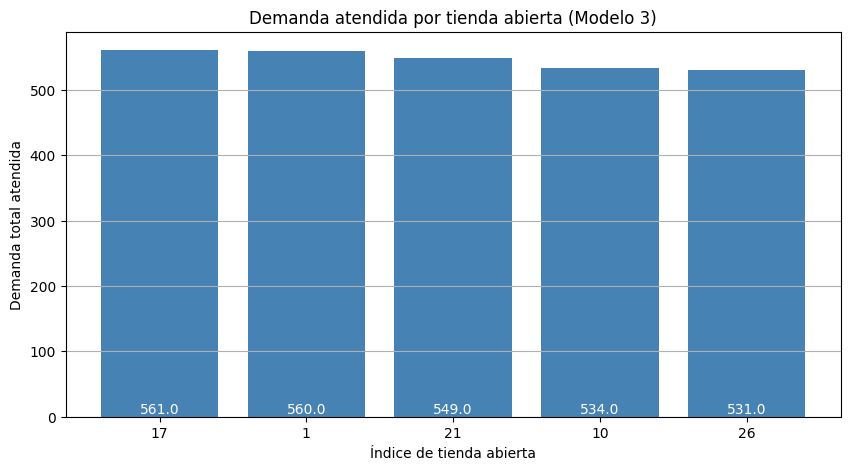

Demanda máx: 561.0
Demanda mín: 531.0
Spread demanda: 30.0


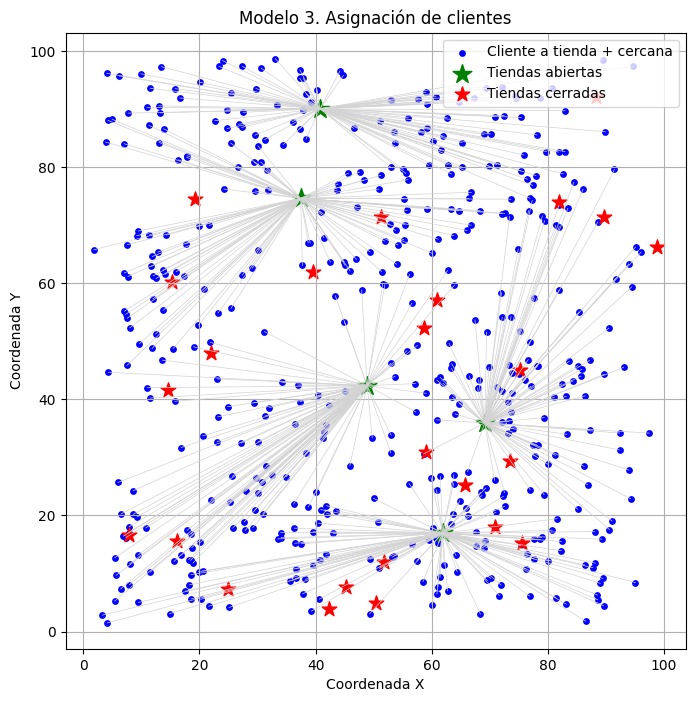

In [14]:
abiertas_m3 = [j for j in J if z3[j].X > 0.5]     # z3 es la binaria de modelo 3

# Demanda total atendida por cada tienda abierta
demanda_por_tienda = {
    j: sum(demandas[i] * x[i, j].X          # asignación del modelo 3
            for i in I)
    for j in abiertas_m3
}

ordenado = sorted(demanda_por_tienda.items(),
                  key=lambda t: t[1], reverse=True)
tiendas, demandas_tot = zip(*ordenado) if ordenado else ([], [])
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(tiendas)), demandas_tot, color="steelblue")

for bar in bars:
    altura = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             0.5,                      
             f"{altura:.1f}",          
             ha="center", va="bottom",
             color="white", fontsize=10)

plt.xticks(range(len(tiendas)), tiendas)
plt.xlabel("Índice de tienda abierta")
plt.ylabel("Demanda total atendida")
plt.title("Demanda atendida por tienda abierta (Modelo 3)")
plt.grid(axis="y")
plt.show()

print(f"Demanda máx: {max(demandas_tot):.1f}")
print(f"Demanda mín: {min(demandas_tot):.1f}")
print(f"Spread demanda: {max(demandas_tot)-min(demandas_tot):.1f}")

# ---------------------------
# 2)  MAPA  Clientes vs. tiendas
# ---------------------------
mal_x, mal_y   = [], []
bien_x, bien_y = [], []
segments       = []

for i in I:
    # tienda efectivamente asignada
    j_asig = next(j for j in J if x[i, j].X > 0.5)
    dist_asig = d[i, j_asig]

    # distancia mínima a cualquiera de las abiertas
    dist_min_abierta = min(d[i, j] for j in abiertas_m3)

    xi, yi = coordenadasI[i]
    if dist_asig > dist_min_abierta + 1e-6:   # tolerancia numérica
        mal_x.append(xi);  mal_y.append(yi)
    else:
        bien_x.append(xi); bien_y.append(yi)

    # segmento visual cliente→tienda asignada
    xj, yj = coordenadasJ[j_asig]
    segments.append(((xi, yi), (xj, yj)))

plt.figure(figsize=(8, 8))
for (x0, y0), (x1, y1) in segments:
    plt.plot([x0, x1], [y0, y1], c="lightgrey", lw=0.5)

# clientes
plt.scatter(bien_x, bien_y, c="blue",  s=15, label="Cliente a tienda + cercana")
if mal_x:
    plt.scatter(mal_x, mal_y, c="red", s=25, label="Cliente NO va a tienda + cercana")

# tiendas
plt.scatter(coordenadasJ[abiertas_m3, 0],
            coordenadasJ[abiertas_m3, 1],
            marker="*", c="green", s=200, label="Tiendas abiertas")
cerradas = [j for j in J if j not in abiertas_m3]
plt.scatter(coordenadasJ[cerradas, 0],
            coordenadasJ[cerradas, 1],
            marker="*", c="red",   s=120, label="Tiendas cerradas")

plt.title("Modelo 3. Asignación de clientes")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.legend(loc="best")
plt.grid(True)
plt.axis("equal")
plt.show()

In [15]:
print("Demandas únicas:", np.unique(demandas))
print("Mínimo, medio, máximo:", demandas.min(), demandas.mean(), demandas.max())

Demandas únicas: [ 1  2  3  4  5  6  7  8  9 10]
Mínimo, medio, máximo: 1 5.47 10


In [18]:
# 1) Cálculo del spread en número de clientes
cargas_clientes = [sum(x[i,j].X for i in I) for j in J if z3[j].X > 0.5]
spread_clientes = max(cargas_clientes) - min(cargas_clientes)

# 2) Cálculo del spread en demanda
cargas_demanda = [sum(demandas[i]*x[i,j].X for i in I) for j in J if z3[j].X > 0.5]
spread_demanda = max(cargas_demanda) - min(cargas_demanda)

print(f"Spread (# clientes): {spread_clientes}")
print(f"Spread (demanda):    {spread_demanda:.2f}")

Spread (# clientes): 16.0
Spread (demanda):    30.00


In [17]:
nI = len(demandas)
nJ = len(coordenadasJ)
I = range(nI)
J = range(nJ)

# Recopilar datos por tienda abierta
data = []
for j in J:
    if z3[j].X > 0.5:
        num_clients   = sum(1 for i in I if x[i,j].X > 0.5)
        total_demand  = sum(demandas[i] * x[i,j].X for i in I)
        data.append({
            'Tienda': j,
            'Clientes': num_clients,
            'Demanda': total_demand
        })

df = pd.DataFrame(data)
print(df)

   Tienda  Clientes  Demanda
0       1       101    560.0
1      10        97    534.0
2      17        95    561.0
3      21       111    549.0
4      26        96    531.0


El modelo 3, al redefinir la carga como demanda total en lugar de número de clientes, hemos ligeramente aumentado el spread por el número de clientes (ha subido del modelo 1 en 8 a 16 en el modelo 3). Sin embargo, el spread de la demanda se mantiene en mínimo en 30 (que era nuestro objetivo).
Esto demuestra que a veces debemos hacer un tradeoff en el modelo para obtener resultados más prácticos en la vida real.

## Ejercicio 4.

**Ejercicio 4.** Resulta que en la ciudad ya está implantada otra cadena de supermercados, *Adli*, que tiene características similares a *Dild* y que por tanto es competencia directa. Los clientes de la ciudad se decantarán por la tienda que tengan más cerca, independientemente de si es de una y otra cadena. La cadena *Adli* cuenta con 8 tiendas, cuyas ubicaciones se proporcionan en la variable **coordenadasH**.

Supón que, en este ejercicio, únicamente se desa saber cuál es el número mínimo de tiendas *Dild* que le permitiría a *Dild* tener más clientes que *Adli*, y dónde podrían estar ubicadas.

Describe el modelo matemático correspondiente, resuévelo con gurobi y describe la solución.

### Modelo matemático

**Conjuntos y parámetros**  
- $I=\{1,\dots,n\}$: clientes.  
- $J=\{1,\dots,m\}$: posibles ubicaciones *Dild*.  
- $H=\{1,\dots,h\}$: ubicaciones fijas de *Adli*.  
- $d_{ij}$: distancia de cliente $i$ a ubicación *Dild* $j$.  
- $h_i=\min_{k\in H} d^H_{ik}$: distancia mínima de $i$ a cualquier tienda *Adli*.
- $T=\bigl\lfloor n/2\bigr\rfloor+1$: número mínimo de clientes que *Dild* debe captar para superar a *Adli*. (250)

**Variables de decisión**  

$$
x_{ij} =
\begin{cases}
1, & \text{si el cliente $i$ se asigna a la tienda $j$},\\
0, & \text{en otro caso},
\end{cases}
\quad i\in I,\;j\in J.
$$

$$
z_{j} =
\begin{cases}
1, & \text{si abrimos una tienda en la ubicación $j$},\\
0, & \text{en otro caso},
\end{cases}
\quad j\in J.
$$


$$
\delta_i \in \{0,1\}, \quad i\in I,
\quad
\delta_i = 1 \iff \exists\,j\in J:\;z_j=1\;\wedge\;d_{ij}<h_i.
$$

**Función objetivo**  
$$
\min\;\sum_{j\in J}z_j.
$$

**Restricciones**  
1. **Cliente $i$ captado sólo si hay alguna tienda más cercana que *Adli***  
   $$
   \delta_i \;\le\;\sum_{j:\,d_{ij}<h_i} z_j,
   \quad \forall\,i\in I.
   $$

2. **Si una tienda *Dild* está más cerca, entonces $\delta_i=1$**  
   $$
   \delta_i \;\ge\; z_j,
   \quad
   \forall\,i\in I,\;\forall\,j\in J\ \text{tal que }d_{ij}<h_i.
   $$

3. **Dild debe captar más de la mitad de los clientes**  
   $$
   \sum_{i\in I}\delta_i \;\ge\; T.
   $$

4. **Cada cliente captado va a una sola tienda Dild**  
   $$
   \sum_{j\in J} x_{ij} = \delta_i,
   \quad \forall\,i\in I.
   $$

5. **Vínculo apertura–asignación**  
   Un cliente sólo puede ir a una tienda si está abierta:
   $$
   x_{ij}\;\le\;z_{j},
   \quad \forall\,i\in I,\;j\in J.
   $$

6. **Asignación a la tienda abierta más cercana**
   $$
   \sum_{a\in J} d_{ia}x_{ia} + (M_i-d_{ij}) z_j \le M_i \quad \forall i\in I,\,j\in J
   $$
   con $M_i \;=\;\max_{j\in J} d_{ij}, \quad\forall i\in I$.

7. **Dominios**  
   $$
   x_{ij}\in\{0,1\},\quad z_j\in\{0,1\},\quad \delta_i\in\{0,1\}.
   $$

---

### Programación del modelo 4

In [24]:
nI = len(coordenadasI)
nJ = len(coordenadasJ)
nH = len(coordenadasH)
I  = range(nI)
J  = range(nJ)
H  = range(nH)

# Matrices de distancia
d = {(i,j): np.hypot(coordenadasI[i,0]-coordenadasJ[j,0],
                     coordenadasI[i,1]-coordenadasJ[j,1])
     for i in I for j in J}
dH= {(i,k): np.hypot(coordenadasI[i,0]-coordenadasH[k,0],
                     coordenadasI[i,1]-coordenadasH[k,1])
     for i in I for k in H}

# h_i = distancia mínima a Adli
h = {i: min(dH[i,k] for k in H) for i in I}

# T = número mínimo de clientes para vencer a Adli
T = nI//2 + 1

# --- Crear modelo ---
m4 = Model("Ej4_Competencia", env=env)
m4.Params.TimeLimit = 1800

# Variables
x = m4.addVars(I, J,    vtype=GRB.BINARY, name="x")    # asignación cliente->tienda
z4    = m4.addVars(J,   vtype=GRB.BINARY, name="z")     # abre Dild en j?
delta = m4.addVars(I,   vtype=GRB.BINARY, name="delta") # cliente i va a Dild

# Objetivo: minimizar número de tiendas Dild
m4.ModelSense = GRB.MINIMIZE
m4.setObjective(quicksum(z4[j] for j in J))

# Restricciones

# 1) delta_i ≤ sum{ z_j : d_ij < h_i }
m4.addConstrs(
    ( delta[i] <= quicksum(z4[j]
         for j in J if d[i,j] < h[i])
      for i in I),
    name="captura_if_open"
)

# 2) delta_i ≥ z_j  ∀ j con d_ij < h_i
m4.addConstrs(
    ( delta[i] >= z4[j]
      for i in I for j in J if d[i,j] < h[i] ),
    name="captura_if_closer"
)

# 3) captar más de la mitad de los clientes
m4.addConstr(quicksum(delta[i] for i in I) >= T,
             name="supera_Adli")

# 4) Cada cliente captado va a una sola tienda Dild
m4.addConstrs(
    (quicksum(x[i,j] for j in J) == delta[i]
     for i in I),
    name="AsignacionUnica"
)

# 5) Sólo se puede asignar a tiendas abiertas
m4.addConstrs(
    (x[i,j] <= z4[j]
     for i in I for j in J),
    name="AperturaAsignacion"
)

# 6) Sólo se puede asignar a la tienda abierta más cercana
# --- Big-M per client ---------------------
M = {i: max(d[i, j] for j in J) for i in I} #como ya no tenemos un p que fijar
m4.addConstrs(
    ( quicksum(d[i, a] * x[i, a] for a in J)
      + (M[i] - d[i, j]) * z4[j] <= M[i]
      for i in I for j in J ),
    name="MasCercanaAbierta"
)

m4.optimize()

# --- Resultados ---
p_opt = sum(int(z4[j].X) for j in J)
abiertas = [j for j in J if z4[j].X > 0.5]
captados = sum(int(delta[i].X) for i in I)

print(f"Número mínimo de tiendas Dild: {p_opt}")
print("Ubicaciones elegidas:", abiertas)
print("Clientes captados por Dild:", captados, "de", nI)


Set parameter TimeLimit to value 1800
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  1800

Academic license 2641339 - for non-commercial use only - registered to jg___@ikasle.ehu.eus
Optimize a model with 32008 rows, 15530 columns and 514021 nonzeros
Model fingerprint: 0x2c5f4e4a
Variable types: 0 continuous, 15530 integer (15530 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+01, 3e+02]
Found heuristic solution: objective 11.0000000
Presolve removed 31458 rows and 15261 columns
Presolve time: 1.26s
Presolved: 550 rows, 269 columns, 1999 nonzeros
Variable types: 0 continuous, 269 integer (269 binary)

Root relaxation: objective 6.058824e+00, 162 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    C

In [25]:
nH #número de tiendas rivales (de la competencia)

8

El mínimo número de tiendas Dild a abrir es 7, aun sabiendo que la competencia tiene 8 tiendas abiertas. La clave es la ubicación, que nos permitiría capturar a un mayor número de clientes que los de la competencia. A continuacion la distribución de clientes en cada una de las tiendas.

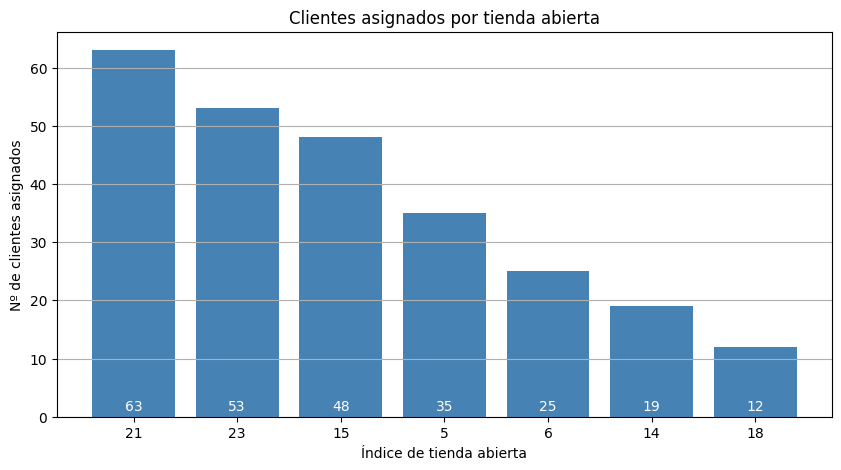

Máx clientes tienda: 63
Mín clientes tienda: 12
Spread: 51


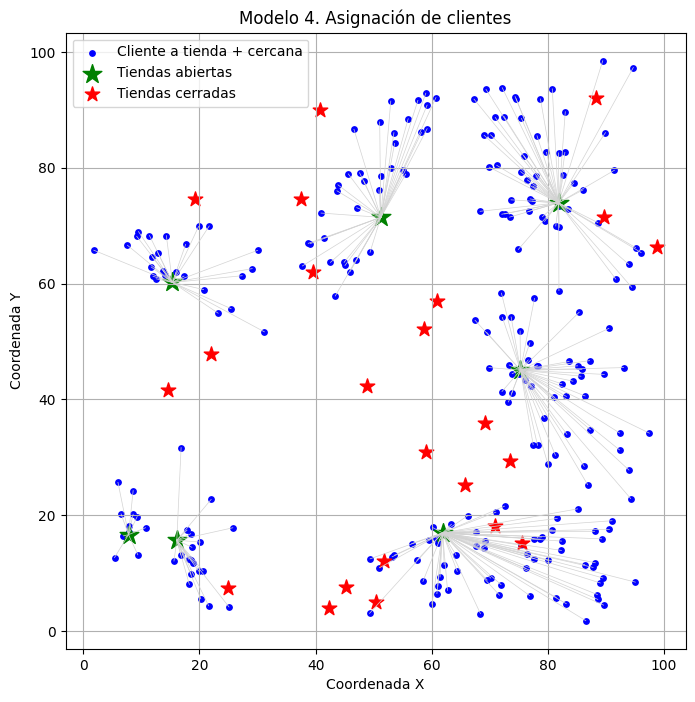

In [27]:
abiertas_ex4 = [j for j in J if z4[j].X > 0.5]

clientes_por_tienda = {
    j: sum(int(x[i, j].X > 0.5) for i in I)     # cuenta clientes asignados
    for j in abiertas_ex4
}
ordenado = sorted(clientes_por_tienda.items(), key=lambda t: t[1], reverse=True)
tiendas, clientes = zip(*ordenado)

plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(tiendas)), clientes, color="steelblue")
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        0.5,                              
        f"{int(height)}",
        ha="center", va="bottom",
        color="white", fontsize=10
    )

plt.xticks(range(len(tiendas)), tiendas)
plt.xlabel("Índice de tienda abierta")
plt.ylabel("Nº de clientes asignados")
plt.title("Clientes asignados por tienda abierta")
plt.grid(axis="y")
plt.show()

print(f"Máx clientes tienda: {max(clientes)}")
print(f"Mín clientes tienda: {min(clientes)}")
print(f"Spread: {max(clientes)-min(clientes)}")

# ---------------------------
# 2)  MAPA  Clientes vs. tiendas
# ---------------------------
mal_x, mal_y   = [], []
bien_x, bien_y = [], []
segments       = []

captados = [i for i in I if delta[i].X > 0.5]
for i in captados:
    # tienda efectivamente asignada
    j_asig = next(j for j in J if x[i, j].X > 0.5)
    dist_asig = d[i, j_asig]

    # distancia mínima a cualquiera de las abiertas
    dist_min_abierta = min(d[i, j] for j in abiertas_ex4)

    xi, yi = coordenadasI[i]
    if dist_asig > dist_min_abierta + 1e-6:
        mal_x.append(xi);  mal_y.append(yi)
    else:
        bien_x.append(xi); bien_y.append(yi)

    # segmento visual cliente→tienda asignada
    xj, yj = coordenadasJ[j_asig]
    segments.append(((xi, yi), (xj, yj)))

plt.figure(figsize=(8, 8))
for (x0, y0), (x1, y1) in segments:
    plt.plot([x0, x1], [y0, y1], c="lightgrey", lw=0.5)
plt.scatter(bien_x, bien_y, c="blue",  s=15, label="Cliente a tienda + cercana")
if mal_x:
    plt.scatter(mal_x, mal_y, c="red", s=25, label="Cliente NO va a tienda + cercana")

# tiendas
plt.scatter(coordenadasJ[abiertas_ex4, 0],
            coordenadasJ[abiertas_ex4, 1],
            marker="*", c="green", s=200, label="Tiendas abiertas")
cerradas = [j for j in J if j not in abiertas_ex4]
plt.scatter(coordenadasJ[cerradas, 0],
            coordenadasJ[cerradas, 1],
            marker="*", c="red",   s=120, label="Tiendas cerradas")

plt.title("Modelo 4. Asignación de clientes")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.legend(loc="best")
plt.grid(True)
plt.axis("equal")
plt.show()

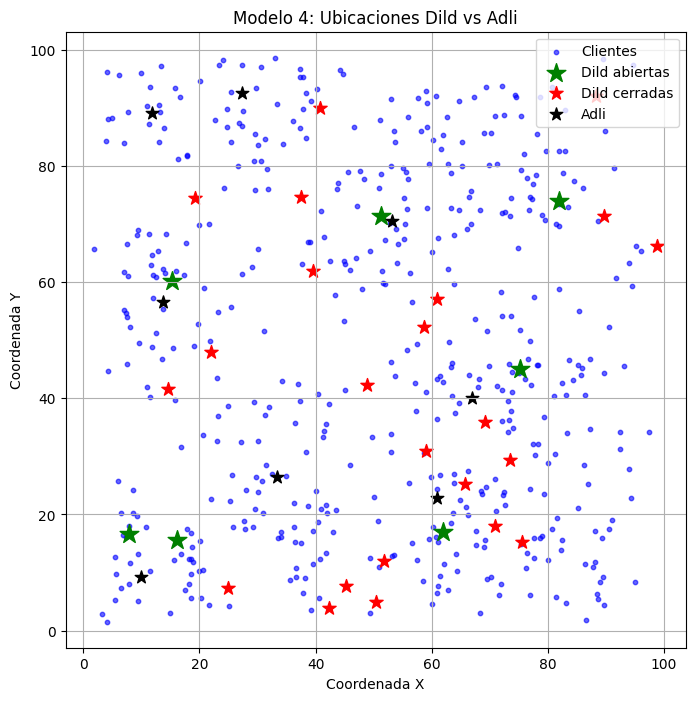

In [29]:
# Índices de ubicaciones Dild según modelo 4
dild_abiertas = [j for j in J if z4[j].X > 0.5]
dild_cerradas = [j for j in J if z4[j].X < 0.5]

plt.figure(figsize=(8,8))

# 1) Clientes en azul
plt.scatter(coordenadasI[:,0], coordenadasI[:,1],
            c='blue', s=10, alpha=0.6, label='Clientes')

# 2) Tiendas Dild abiertas en verde
plt.scatter(coordenadasJ[dild_abiertas,0],
            coordenadasJ[dild_abiertas,1],
            marker='*', c='green', s=200,
            label='Dild abiertas')

# 3) Tiendas Dild cerradas en rojo
plt.scatter(coordenadasJ[dild_cerradas,0],
            coordenadasJ[dild_cerradas,1],
            marker='*', c='red', s=100,
            label='Dild cerradas')

# 4) Tiendas Adli en negro
plt.scatter(coordenadasH[:,0], coordenadasH[:,1],
            marker='*', c='black', s=90,
            label='Adli')

# Leyenda y formato
plt.legend(loc='best')
plt.title('Modelo 4: Ubicaciones Dild vs Adli')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.grid(True)
plt.axis('equal')
plt.show()


El modelo competitivo determina cuántas tiendas Dild bastan para superar a Adli en número de clientes. Con la configuración actual el optimizador abre 7 establecimientos (índices [5, 6, 14, 15, 18, 21, 23]) y conquista 255 de 500 clientes, es decir, más de la mitad de la demanda urbana.

La solución reparte esa clientela entre las tiendas abiertas con una carga que oscila entre 12 y 63 clientes, lo que deja un *spread* de 51.  Pese a no buscar explícitamente el equilibrio, la dispersión resultante es razonable y confirma que la clave está en colocar los puntos de venta allí donde son estrictamente la opción más cercana para bloques relevantes de consumidores. De ese modo Dild gana cuota abriendo incluso menos locales (7) que la competencia (8) y concentra su inversión en ubicaciones de alto impacto.